In [26]:
import neurodsp as dsp # git cloned zeropad branch
import mne
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('C:\\Users\\dillc\\OneDrive\\UCSD\\Voytek_Lab\\johnson_data_reanalysis\\johnson_data_reanalysis')
from utils.channel_selection import get_roi_channels, get_task_channels

In [2]:
#mne.sys_info()

In [3]:
? dsp.spectral.compute_spectrum

Signature:
 dsp.spectral.compute_spectrum(
    sig,
    fs,
    method='welch',
    avg_type='mean',
    **kwargs,
)
Docstring:
Compute the power spectral density of a time series.

Parameters
----------
sig : 1d or 2d array
    Time series.
fs : float
    Sampling rate, in Hz.
method : {'welch', 'wavelet', 'medfilt'}, optional
    Method to use to estimate the power spectrum.
avg_type : {'mean', 'median'}, optional
    If relevant, the method to average across windows to create the spectrum.
**kwargs
    Keyword arguments to pass through to the function that calculates the spectrum.

Returns
-------
freqs : 1d array
    Frequencies at which the measure was calculated.
spectrum : 1d or 2d array
    Power spectral density.

Examples
--------
Compute the power spectrum of a simulated time series:

>>> from neurodsp.sim import sim_combined
>>> sig = sim_combined(n_seconds=10, fs=500,
...                    components={'sim_powerlaw': {}, 'sim_oscillation' : {'freq': 10}})
>>> freqs, spect

## Read data

In [13]:
# inspect preprocessed subs
preproc_eps = r'D:\\Johnson\\preproc\\epochs\\'
allpp = os.listdir(preproc_eps)
print(allpp)
# get channel ROI labels
chs_labels = pd.read_csv(r"D:\Johnson\preproc\df_johnson_electrode_info.csv")
chs_labels.head(5)

['10_wholeTrialEpochs-epo.fif', '11_wholeTrialEpochs-epo.fif', '12_wholeTrialEpochs-epo.fif', '13_wholeTrialEpochs-epo.fif', '14_wholeTrialEpochs-epo.fif', '15_wholeTrialEpochs-epo.fif', '16_wholeTrialEpochs-epo.fif', '17_wholeTrialEpochs-epo.fif', '1_wholeTrialEpochs-epo.fif', '2_wholeTrialEpochs-epo.fif', '4_wholeTrialEpochs-epo.fif', '5_wholeTrialEpochs-epo.fif', '6_wholeTrialEpochs-epo.fif', '7_wholeTrialEpochs-epo.fif', '8_wholeTrialEpochs-epo.fif', '9_wholeTrialEpochs-epo.fif']


,Unnamed: 0,patient,laterality,region,electrode
0,0,s1,R,MTL,RHD2
1,1,s1,R,MTL,RTHD1
2,2,s1,R,PFC,RCD8
3,3,s1,R,PFC,RCD9
4,4,s1,R,PFC,RCD10


In [15]:
# Load example subject
s3_eps = mne.read_epochs(fname=preproc_eps+allpp[3])
chs = s3_eps.info['ch_names']
print(len(chs))
fs = s3_eps.info['sfreq']
channels_dict = get_roi_channels(subjectID='13',electrode_info=chs_labels, exempt_sub=1)
# separate conditions of interest
ids = s3_eps[s3_eps.metadata['cue_one_condition']=='id']
rels = s3_eps[s3_eps.metadata['cue_one_condition']=='rel']

Reading D:\Johnson\preproc\epochs\13_wholeTrialEpochs-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5599.61 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
119 matching events found
No baseline correction applied
0 projection items activated
256
Identifying ROI channels


In [37]:
s3_eps.info

<Info | 12 non-empty values
 bads: 14 items (R-0, R-1, R-128, R-192, R-63, R-0, R-1, R-63, R-128, ...)
 ch_names: R-2, R-3, R-4, R-5, R-6, R-7, R-8, R-9, R-10, R-11, R-12, R-13, ...
 chs: 256 ECoG
 custom_ref_applied: True
 dig: 0 items
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 150.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 256
 projs: []
 sfreq: 512.0 Hz
>

------------------------------------------------

## Get data for each condition, only subselecting PFC contacts and times corresponding to Delay 1
## Results in 900ms time window from which to estimate timescales

In [53]:

ids_data = ids.get_data(picks=channels_dict['PFC'], tmin=2.5,tmax=3.4)
rels_data = rels.get_data(picks=channels_dict['PFC'], tmin=2.5,tmax=3.4)
# shape n_epochs, n_channels, n_samples
print(ids_data.shape)
print(rels_data.shape)
# avg over channels to get 2D matrix
ids_data = ids_data.mean(axis=1)
rels_data = rels_data.mean(axis=1)
print(ids_data.shape)
print(rels_data.shape)


(39, 54, 460)
(80, 54, 460)
(39, 460)
(80, 460)


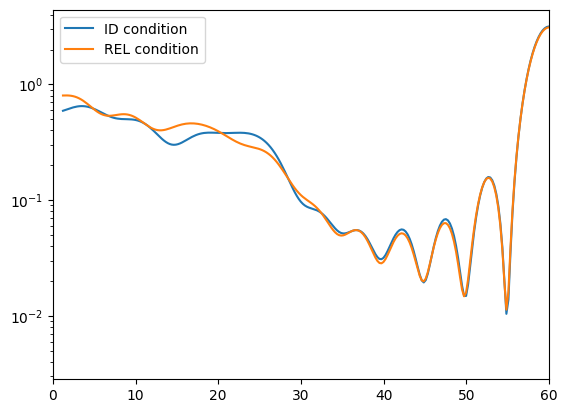

In [54]:
nperseg = 100
noverlap = int(nperseg*0.20)
npad=1000
f_range = (1,100)

f_id, p_id = dsp.spectral.compute_spectrum(sig=ids_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
f_rel, p_rel = dsp.spectral.compute_spectrum(sig=rels_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
plt.semilogy(f_id, p_id.mean(axis=0), label='ID condition') # averaging Power Spec across epochs -- this will make them less noisy as well obvs
plt.semilogy(f_rel, p_rel.mean(axis=0), label='REL condition')
plt.xlim(0,60)
plt.legend();

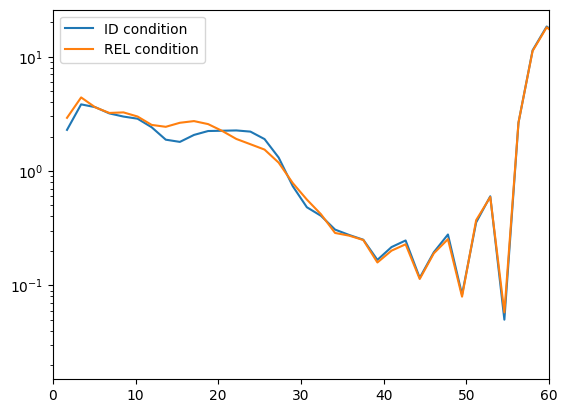

In [55]:
# decrease zero padding by a factor of 10
npad=100

f_id, p_id = dsp.spectral.compute_spectrum(sig=ids_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
f_rel, p_rel = dsp.spectral.compute_spectrum(sig=rels_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
plt.semilogy(f_id, p_id.mean(axis=0), label='ID condition')
plt.semilogy(f_rel, p_rel.mean(axis=0), label='REL condition')
plt.xlim(0,60)
plt.legend();

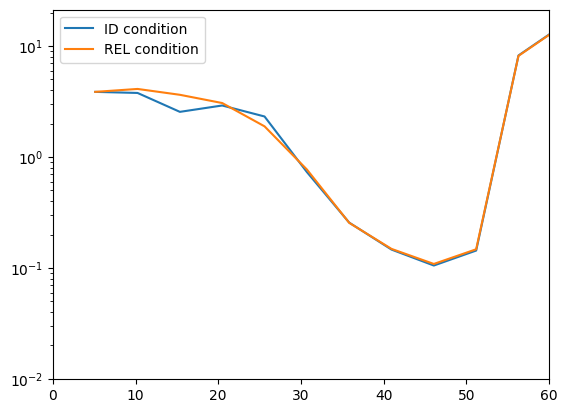

In [56]:
# decrease to zero
npad=0

f_id, p_id = dsp.spectral.compute_spectrum(sig=ids_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
f_rel, p_rel = dsp.spectral.compute_spectrum(sig=rels_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
plt.semilogy(f_id, p_id.mean(axis=0), label='ID condition')
plt.semilogy(f_rel, p_rel.mean(axis=0), label='REL condition')
plt.xlim(0,60)
plt.legend();

--------------------------------

# Examine relationship w/ length of signal 

(119, 512)
(119, 1024)
(119, 1536)


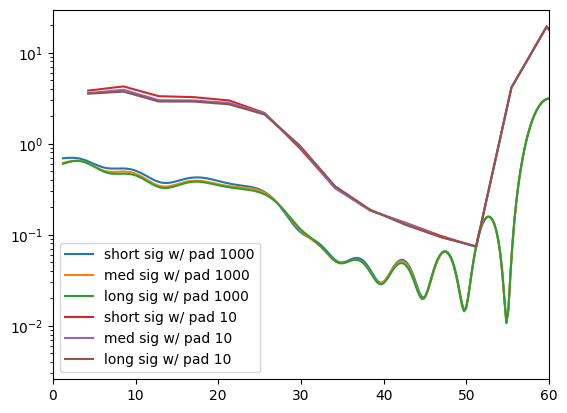

In [62]:
# get data for all conditions, only subselecting PFC contacts and times corresponding to Delay 1
short_data = s3_eps.get_data(picks=channels_dict['PFC'], tmin=2.5,tmax=3.5).mean(axis=1) # 1 sec of data
med_data = s3_eps.get_data(picks=channels_dict['PFC'], tmin=2.5,tmax=4.5).mean(axis=1) # 2 secs
long_data = s3_eps.get_data(picks=channels_dict['PFC'], tmin=2.5,tmax=5.5).mean(axis=1) # 3 secs

# shape n_epochs, n_channels, n_samples
print(short_data.shape)
print(med_data.shape)
print(long_data.shape)

nperseg = 100
noverlap = int(nperseg*0.20)
f_range = (1,100)

npad=1000
f_short, p_short = dsp.spectral.compute_spectrum(sig=short_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
f_med, p_med = dsp.spectral.compute_spectrum(sig=med_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
f_long, p_long = dsp.spectral.compute_spectrum(sig=long_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
plt.semilogy(f_short, p_short.mean(axis=0), label=('short sig w/ pad {0}').format(str(npad))) # averaging Power Spec across epochs -- this will make them less noisy as well obvs
plt.semilogy(f_med, p_med.mean(axis=0), label=('med sig w/ pad {0}').format(str(npad)))
plt.semilogy(f_long, p_long.mean(axis=0), label=('long sig w/ pad {0}').format(str(npad)))
plt.xlim(0,60)


npad=10
f_short, p_short = dsp.spectral.compute_spectrum(sig=short_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
f_med, p_med = dsp.spectral.compute_spectrum(sig=med_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
f_long, p_long = dsp.spectral.compute_spectrum(sig=long_data, fs=fs, nperseg=nperseg, noverlap=noverlap, npad=npad, f_range=f_range)
plt.semilogy(f_short, p_short.mean(axis=0), label=('short sig w/ pad {0}').format(str(npad))) # averaging Power Spec across epochs -- this will make them less noisy as well obvs
plt.semilogy(f_med, p_med.mean(axis=0), label=('med sig w/ pad {0}').format(str(npad)))
plt.semilogy(f_long, p_long.mean(axis=0), label=('long sig w/ pad {0}').format(str(npad)))
plt.xlim(0,60)


plt.legend();